In [86]:
### Importo todas las librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd #principal herramienta de gestion de datasets como dataframe
import numpy as np #para trabajar con arrays y algunas cuestiones estadisticas
import joblib #sirve para bajar el modelo entrenado y guardarlo como un achivo
import matplotlib.pyplot as plt  #herramienta grafica
import seaborn as sns #herramienta grafica
sns.set()

from sklearn.preprocessing import StandardScaler # herramienta para optimizacion del modelo
from sklearn.model_selection import train_test_split #metricas
from sklearn.model_selection import cross_val_score #metricas
from sklearn.model_selection import cross_validate #metricas

from sklearn.tree import DecisionTreeClassifier #modelo de arbol

import sklearn.metrics as metrics #metricas
from sklearn.model_selection import learning_curve 
from sklearn.preprocessing import OneHotEncoder # preprocesamiento de columna
from sklearn.preprocessing import OrdinalEncoder # preprocesamiento de columna
from sklearn import preprocessing # preprocesamiento de columna

In [44]:
!git clone https://github.com/soyHenry/Datathon.git #clono el repositorio

fatal: destination path 'Datathon' already exists and is not an empty directory.


In [45]:
df_train=pd.read_csv('Datathon/hospitalizaciones_train.csv') #ingesto los datos en dataframe de pandas

In [46]:
df_new=df_train.copy() #hago una copia para resguardar los datos en crudo

In [90]:
def transf_label(df): #creo una función para transforar la label
    lista_dias=df['Stay (in days)']
    lista_estancia=[]
    for i in lista_dias:
        if i <=8: 
            i=0
        elif i>8:
            i=1
        lista_estancia.append(i)
    array_estancia=np.array(lista_estancia)
    array_estancia.reshape(1,-1)
    array_estancia.shape
    df['estancia']=array_estancia
    df.drop(columns=['Stay (in days)'], inplace=True)
    return df

In [48]:
transf_label(df_new) #aplico la función

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,estancia
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,0
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,1
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,0
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,0
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409995,1,gynecology,D,Dr Sarah,1,63105,31-40,Female,Trauma,Minor,Asthama,3,Yes,3902.291076,0
409996,5,gynecology,D,Dr Nathan,5,129292,21-30,Female,Trauma,Extreme,Other,4,No,4771.995223,1
409997,4,gynecology,D,Dr Sarah,9,11399,21-30,Female,Emergency,Minor,Asthama,4,Yes,3816.994210,1
409998,10,gynecology,D,Dr Olivia,10,75003,21-30,Female,Trauma,Moderate,Other,2,Yes,3841.577491,1


Para las features, algunas columnas recibirán el tratamiento de labelEncoder, otras categóricas la herramienta para categoricas y finalmente, donde nos interesa la correlacion de una categoria puntal, se hace one hot OneHotEncoder

In [49]:
le = preprocessing.LabelEncoder()
df_new['Insurance'] = le.fit_transform(df_new['Insurance'])
df_new['Ward_Facility_Code'] = le.fit_transform(df_new['Ward_Facility_Code'])
df_new['gender'] = le.fit_transform(df_new['gender'])

In [50]:
df_new=df_new.drop(columns=['patientid']) # IMPORTANTE: la razon por la que quitamos esta columna es porque puede overfittear el modelo y es un id_ no corresponde analizarla como feature

In [51]:
#columnas para hacer OneHotEncoder:
df_new['Department'].unique()

array(['gynecology', 'anesthesia', 'TB & Chest disease', 'radiotherapy',
       'surgery'], dtype=object)

In [52]:
df_new['Type of Admission'].unique()

array(['Trauma', 'Urgent', 'Emergency'], dtype=object)

In [53]:
df_new['doctor_name'].unique()

array(['Dr Sophia', 'Dr Olivia', 'Dr Mark', 'Dr John', 'Dr Sarah',
       'Dr Sam', 'Dr Nathan', 'Dr Simon', 'Dr Isaac'], dtype=object)

In [54]:
df_new['health_conditions'].unique()

array(['Diabetes', 'Heart disease', 'None', 'Other', 'Asthama',
       'High Blood Pressure'], dtype=object)

In [55]:
ohe=OneHotEncoder() 

In [56]:
feature_array=ohe.fit_transform(df_new[['Department','doctor_name','Type of Admission','health_conditions']]).toarray()

In [57]:
feature_labels=ohe.categories_

In [58]:
feature_labels=np.array(feature_labels).ravel()

<ipython-input-58-c2a9e482d40a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  feature_labels=np.array(feature_labels).ravel()


In [59]:
lista_aux=[]
for i in feature_labels:
  for e in i: 
    lista_aux.append(e)
print(lista_aux)

['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy', 'surgery', 'Dr Isaac', 'Dr John', 'Dr Mark', 'Dr Nathan', 'Dr Olivia', 'Dr Sam', 'Dr Sarah', 'Dr Simon', 'Dr Sophia', 'Emergency', 'Trauma', 'Urgent', 'Asthama', 'Diabetes', 'Heart disease', 'High Blood Pressure', 'None', 'Other']


In [60]:
feature_labels=lista_aux

In [61]:
df_extra=pd.DataFrame(feature_array,columns=feature_labels)

In [62]:
enc = OrdinalEncoder()
X2=[['0-10',1],['11-20',2],['21-30',3],['31-40',4],['41-50',5],['51-60',6],['61-70',7],['71-80',8],['81-90',9],['91-100',10]]
enc.fit(X2)
df_new['Age'] = enc.fit_transform(df_new[['Age']])

In [63]:
enc = OrdinalEncoder()
X3=['Minor',1],['Moderate',2],['Extreme',3]
enc.fit(X3)
df_new['Severity of Illness'] = enc.fit_transform(df_new[['Severity of Illness']])

In [64]:
df_new.drop(columns=['Department','doctor_name','Type of Admission','health_conditions'], inplace=True)

In [65]:
df_nuevo=df_new.join(df_extra)

Finalmente el dataframe para trabajar, desde donde extraemos las features que nos interesa, guardamos la copia por si hay que repensar los features

In [66]:
df5=df_nuevo.copy()

In [67]:
df_nuevo.sample(5)

,Available Extra Rooms in Hospital,Ward_Facility_Code,staff_available,Age,gender,Severity of Illness,Visitors with Patient,Insurance,Admission_Deposit,estancia,...,Dr Sophia,Emergency,Trauma,Urgent,Asthama,Diabetes,Heart disease,High Blood Pressure,None,Other
86518,4,3,1,3.0,0,2.0,4,1,4697.098092,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
357123,2,1,3,3.0,0,0.0,2,1,4678.730302,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
40375,3,4,1,4.0,1,2.0,2,1,5306.281677,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
169473,2,5,8,2.0,0,2.0,4,1,2753.073146,1,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
360063,4,3,9,3.0,0,1.0,8,1,4790.305348,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [68]:
df_f=df_nuevo[['anesthesia','gynecology','Ward_Facility_Code','Dr Mark','Age','gender','TB & Chest disease','Insurance','estancia']]

X=df_nuevo[['anesthesia','gynecology','Ward_Facility_Code','Dr Mark','Age','gender','TB & Chest disease','Insurance']]
y=df_nuevo[['estancia']]

In [69]:
#realizo la primera partición de los datos, luego se hará una validación cruzada

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20) 

# datos, dejo un 20% para testear

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(287000, 8) (287000, 1) (123000, 8) (123000, 1)


In [70]:
#intancio el modelo
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

<ipython-input-70-d926fff5c77a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=42)

In [71]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.6844878048780488
0.6850975609756098


In [72]:
clf.oob_score_

0.6844878048780488

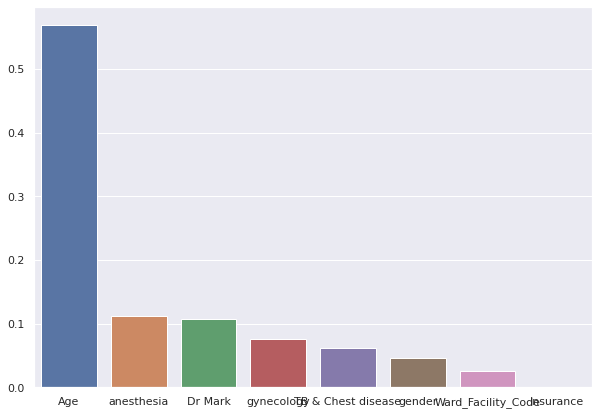

In [73]:
# Diagrama de barras de la importancia de los atributos
importances = clf.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (10,7))
sns.barplot(x = columns[indices], y = importances[indices])
plt.show()

In [74]:
clf.estimators_

[DecisionTreeClassifier(max_features='sqrt', random_state=1608637542),
 DecisionTreeClassifier(max_features='sqrt', random_state=1273642419),
 DecisionTreeClassifier(max_features='sqrt', random_state=1935803228),
 DecisionTreeClassifier(max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_features='sqrt', random_state=996406378),
 DecisionTreeClassifier(max_features='sqrt', random_state=1201263687),
 DecisionTreeClassifier(max_features='sqrt', random_state=423734972),
 DecisionTreeClassifier(max_features='sqrt', random_state=415968276),
 DecisionTreeClassifier(max_features='sqrt', random_state=670094950),
 DecisionTreeClassifier(max_features='sqrt', random_state=1914837113),
 DecisionTreeClassifier(max_features='sqrt', random_state=669991378),
 DecisionTreeClassifier(max_features='sqrt', random_state=429389014),
 DecisionTreeClassifier(max_features='sqrt', random_state=249467210),
 DecisionTreeClassifier(max_features='sqrt', random_state=1972458954),
 DecisionTreeC

In [75]:
#Elijo, aleatoriamente, uno de los árboles del bosque
clf_tree = clf.estimators_[50]
clf_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1224821422,
 'splitter': 'best'}

In [76]:
# Predigo y evaluo en train y test

y_train_pred = clf_tree.predict(X_train)
y_test_pred = clf_tree.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.6844878048780488
0.6850975609756098


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [77]:
train_accuracy = []
test_accuracy = []
oob_scores = []

N_estimadores = [1,2,3,4,5,10,25,50,100,250,500,1000]
for estimadores in N_estimadores:
    print(estimadores)
    clf = RandomForestClassifier(n_estimators=estimadores, n_jobs=-1, oob_score= True, random_state = 42)
    clf.fit(X_train,y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    train_accuracy.append(metrics.accuracy_score(y_train, y_train_pred))
    test_accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    oob_scores.append(clf.oob_score_)
    
train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)
oob_scores = np.array(oob_scores)

<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


1


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


2


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


3


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


4


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


5


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


25


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


50


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


100


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


250


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


500


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


1000


<ipython-input-77-730a36c6f329>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


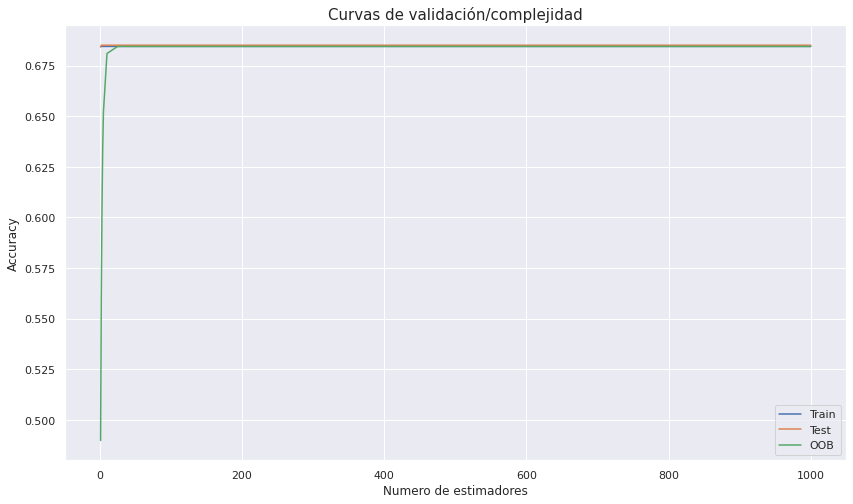

In [78]:
plt.figure(figsize = (14,8))
plt.plot(N_estimadores, train_accuracy, label = 'Train')
plt.plot(N_estimadores, test_accuracy, label = 'Test')
plt.plot(N_estimadores, oob_scores, label = 'OOB')
plt.xlabel('Numero de estimadores')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curvas de validación/complejidad', fontsize = 15)
# plt.xlim(0,50)
plt.show()

No conforme con el resultado vuelvo a correr el arbol con todas las columnas ya procesadas, aumentado el # de arboles y la profundidad de cada uno

In [79]:
df_nuevo.columns

Index(['Available Extra Rooms in Hospital', 'Ward_Facility_Code',
       'staff_available', 'Age', 'gender', 'Severity of Illness',
       'Visitors with Patient', 'Insurance', 'Admission_Deposit', 'estancia',
       'TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy',
       'surgery', 'Dr Isaac', 'Dr John', 'Dr Mark', 'Dr Nathan', 'Dr Olivia',
       'Dr Sam', 'Dr Sarah', 'Dr Simon', 'Dr Sophia', 'Emergency', 'Trauma',
       'Urgent', 'Asthama', 'Diabetes', 'Heart disease', 'High Blood Pressure',
       'None', 'Other'],
      dtype='object')

In [80]:
X2=df_nuevo.drop(columns=['estancia'])
y2=df_nuevo[['estancia']]

In [81]:
#realizo la primera partición de los datos, luego se hará una validación cruzada

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=20) 

# datos, dejo un 20% para testear

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(287000, 8) (287000, 1) (123000, 8) (123000, 1)


In [82]:
clf2 = RandomForestClassifier(n_estimators=250, max_depth=8, max_features='sqrt', oob_score = True, random_state = 42)
clf2.fit(X2_train,y2_train)

<ipython-input-82-7cb097bdea59>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf2.fit(X2_train,y2_train)


RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=250,
                       oob_score=True, random_state=42)

In [83]:
y2_train_pred = clf2.predict(X2_train)
y2_test_pred = clf2.predict(X2_test)
print(metrics.accuracy_score(y2_train, y2_train_pred))
print(metrics.accuracy_score(y2_test, y2_test_pred))

0.6981432926829269
0.698560975609756


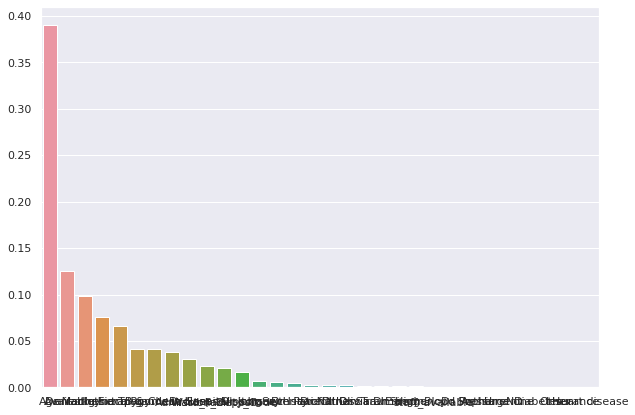

In [84]:
# Diagrama de barras de la importancia de los atributos
importances = clf2.feature_importances_
columns = X2_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (10,7))
sns.barplot(x = columns[indices], y = importances[indices])
plt.show()

guardo el modelo entrenado

In [87]:
joblib.dump(clf2,'randomforest_entrenado')

['randomforest_entrenado']

importo el test y lo corro

In [88]:
df_test_f=pd.read_csv('Datathon/hospitalizaciones_test.csv')

In [92]:
le = preprocessing.LabelEncoder()
df_test_f['Insurance'] = le.fit_transform(df_test_f['Insurance'])
df_test_f['Ward_Facility_Code'] = le.fit_transform(df_test_f['Ward_Facility_Code'])
df_test_f['gender'] = le.fit_transform(df_test_f['gender'])

In [ ]:
df_new=df_new.drop(columns=['patientid']) # IMPORTANTE: la razon por la que quitamos esta columna es porque puede overfittear el modelo y es un id_ no corresponde analizarla como feature

In [104]:
#columnas para hacer OneHotEncoder:
ohe=OneHotEncoder() 
feature_array2=ohe.fit_transform(df_test_f[['Department','doctor_name','Type of Admission','health_conditions']]).toarray()

In [106]:
ohe.categories_

[array(['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy',
        'surgery'], dtype=object),
 array(['Dr Isaac', 'Dr John', 'Dr Mark', 'Dr Nathan', 'Dr Olivia',
        'Dr Sam', 'Dr Sarah', 'Dr Simon', 'Dr Sophia'], dtype=object),
 array(['Emergency', 'Trauma', 'Urgent'], dtype=object),
 array(['Asthama', 'Diabetes', 'Heart disease', 'High Blood Pressure',
        'None', 'Other'], dtype=object)]

In [107]:
feature_labels2=ohe.categories_

In [108]:
feature_labels2=np.array(feature_labels2).ravel()

<ipython-input-108-0a3778f1106d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  feature_labels2=np.array(feature_labels2).ravel()


In [111]:
lista_aux2=[]
for i in feature_labels2:
  for e in i: 
    lista_aux2.append(e)
print(lista_aux2)

['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy', 'surgery', 'Dr Isaac', 'Dr John', 'Dr Mark', 'Dr Nathan', 'Dr Olivia', 'Dr Sam', 'Dr Sarah', 'Dr Simon', 'Dr Sophia', 'Emergency', 'Trauma', 'Urgent', 'Asthama', 'Diabetes', 'Heart disease', 'High Blood Pressure', 'None', 'Other']


In [112]:
feature_labels2=lista_aux2

In [113]:
df_extra2=pd.DataFrame(feature_array2,columns=feature_labels2)

In [114]:
enc = OrdinalEncoder()
X2=[['0-10',1],['11-20',2],['21-30',3],['31-40',4],['41-50',5],['51-60',6],['61-70',7],['71-80',8],['81-90',9],['91-100',10]]
enc.fit(X2)
df_test_f['Age'] = enc.fit_transform(df_test_f[['Age']])

In [115]:
enc = OrdinalEncoder()
X3=['Minor',1],['Moderate',2],['Extreme',3]
enc.fit(X3)
df_test_f['Severity of Illness'] = enc.fit_transform(df_test_f[['Severity of Illness']])

In [116]:
df_test_f.drop(columns=['Department','doctor_name','Type of Admission','health_conditions'], inplace=True)


In [117]:
df_final=df_test_f.join(df_extra2)

In [ ]:
#RELIZO LA PREDICCION FINAL CON EL DATASET DE TEST

In [125]:
Xf=df_final.drop(columns='patientid')

In [126]:
y_test_pred_f=clf2.predict(Xf)

In [127]:
type(y_test_pred_f)

numpy.ndarray

In [128]:
df_f2=pd.DataFrame()

In [129]:
df_f2['pred']=y_test_pred_f

In [134]:
df_f2.sample(5)

,pred
81476,1
88327,1
76953,1
87407,1
78462,1


In [135]:
import os
from pathlib import Path as pl

In [136]:
#EXPORTO EL ARCHIVO COMO CSV _ PARA LA ENTREGA 

In [137]:
filepath = pl('csv_prediccion_rforest/alitfasce.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_f2.to_csv(filepath,
                 sep= ",",
                 na_rep= "null",
                 header= True,
                 index= False,
                 index_label= None,
                 mode= "w",
                 encoding= "utf-8",
                 compression= "infer",            
                 decimal= "."
                 ) 
os.makedirs('csv_prediccion_rforest', exist_ok=True)  
df_f2.to_csv('csv_prediccion_rforest/alitfasce.csv', index=False) 